In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click to toggle code"></form>''')

In [2]:
!rm -Rf ~/.cache/rootpy pax_*
import os, sys
import numpy as np
from multihist import Histdd, Hist1d
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'   # enable if you have a retina display
import pandas as pd
from scipy.optimize import curve_fit, minimize
pd.options.mode.chained_assignment = None        # default='warn'
import warnings
warnings.filterwarnings('ignore')

from scipy.interpolate import interp1d
from scipy.special import erf
from scipy.stats import chi2
from numpy import sqrt, exp, pi

def plt_config(title = None, xbounds = None, ybounds = None, xlabel = None, ylabel = None, colorbar = False, sci = False):
    if sci:
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    if title != None: plt.title(title)
    if xbounds != None: plt.xlim(xbounds)
    if ybounds != None: plt.ylim(ybounds)
    if xlabel != None: plt.xlabel(xlabel)
    if ylabel != None:  plt.ylabel(ylabel)
    if isinstance(colorbar,str):
        plt.colorbar(label = colorbar)
    elif colorbar:
        plt.colorbar(label = 'Number of entries')
    else:
        pass

# Make multihist even easier to use
from contextlib import contextmanager
@contextmanager
def plotting2d(coor):
    if isinstance(coor, list):
        ax = fig.add_subplot(*coor)
    else:
        ax = fig.add_subplot(coor)
    yield ax
    global mh
    mh.plot(log_scale = True, cmap=plt.get_cmap('viridis'), alpha = 1.0 )

@contextmanager
def plotting1d(coor):
    if isinstance(coor, list):
        ax = fig.add_subplot(*coor)
    else:
        ax = fig.add_subplot(coor)
    yield ax
    global ph
    ph.plot()


### Prospective S2 Single Scatter Cut

- Tianyu Zhu, Alexander Shaw July 5

#### Motivation

- With the knowledge of that __single electrons__ (SE) and __multi-electron-pile-ups__ (pile-up) making up the mojority of the S2 background, here we try to separate a true scatter S2 peak from those backgrounds.

- After the study on quantitatively describing the probability of other largest S2s being just a SE peak or a pile-up and using likelihood ratio test to classify peaks. We realized that pile-ups are what limiting our cut while SEs can be easily identified.

- The reason why pile-ups limit our capability to improve the cut is that they are exactly the same as low energy true scatters in area, width, time_delay_from_main_s1 space, which unfortunately our likelihood ratio test was built on.

##### Introduction

- The the main goal here is still to tell single electron and pile-up from a true scatter. The figures shown below depict those cases, as true scatters would be larger, and have an expected width from diffusion model, while single electron and pile-up would be relatively smaller.

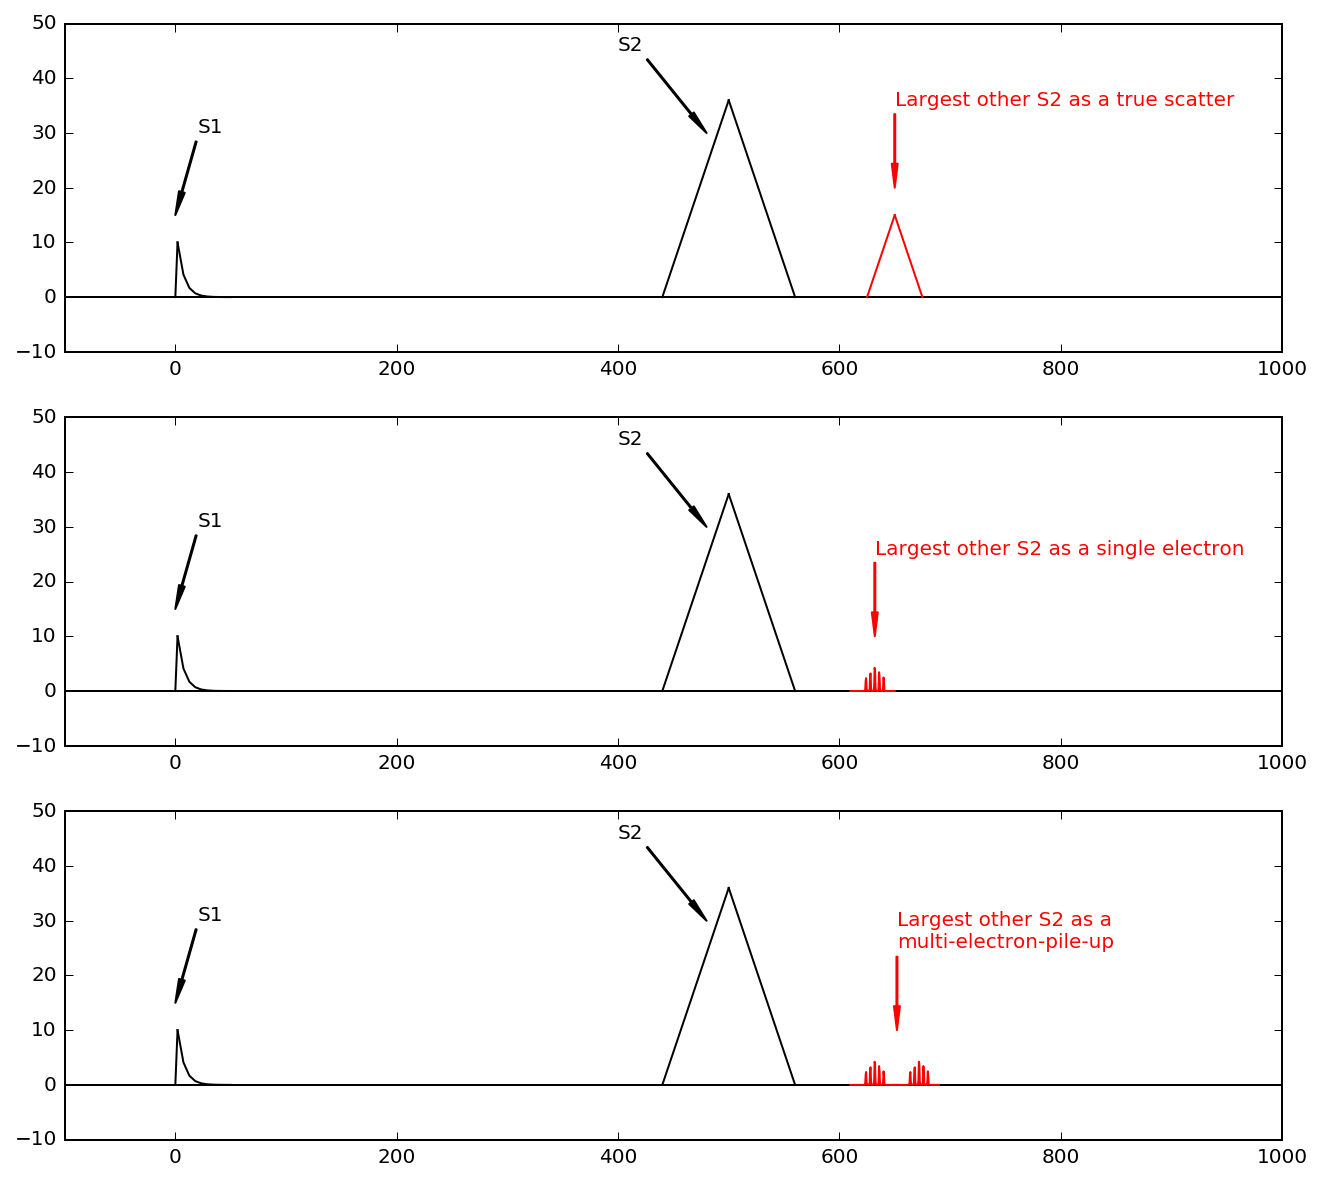

In [3]:
# Make some figures for demo
plt.rcParams['figure.figsize'] = (24, 10)
plt.rcParams['font.size'] = 10
fig = plt.figure()

def plot_s1(time):
    x = np.linspace(time,time+2,10)
    plt.plot(x, 5*(x-time), 'k-')
    x = np.linspace(time+2,time+50,10)
    plt.plot(x, 10*np.exp(-(x-time-2)/6),'k-')
    
def plot_s2(time,h = 36, c = 'k'):
    x = np.linspace(time-h/0.6,time,10)
    plt.plot(x,h+0.6*(x-time),'-',color = c)
    x = np.linspace(time,time+h/0.6,10)
    plt.plot(x,h-0.6*(x-time),'-',color = c)
    
def plot_se(time,c = 'r'):
    x = np.linspace(time-10,time+30,100)   
    def g(x,mu,a):
        return np.exp(-(x-mu)**2/0.2)*a
    y=0
    for mu in time + np.asarray([1,2,3,4,5])*4:
        y+=g(x,mu,5-abs(mu-time-12)*0.3)
        
    plt.plot(x,y,'-',color = c)

ax = fig.add_subplot(321)
plt.axhline(0,color = 'k',ls = '-')
plt_config(xbounds = [-100,1e3], ybounds = [-10,50])
plot_s1(0)
plot_s2(500)
plot_s2(650,h = 15,c = 'r')
ax.annotate('S1', xy=(0, 15), xytext=(20, 30),
            arrowprops=dict(facecolor='black', width = 0.5,headwidth = 3.0))
ax.annotate('S2', xy=(480, 30), xytext=(400, 45),
            arrowprops=dict(facecolor='black', width = 0.5,headwidth = 3.0))
ax.annotate('Largest other S2 as a true scatter', xy=(650, 20), xytext=(650, 35), color = 'r',
            arrowprops=dict(facecolor='red', width = 0.5,headwidth = 3.0,color = 'r'))



ax = fig.add_subplot(323)
plt.axhline(0,color = 'k',ls = '-')
plt_config(xbounds = [-100,1e3], ybounds = [-10,50])
plot_s1(0)
plot_s2(500)
plot_se(620)
ax.annotate('S1', xy=(0, 15), xytext=(20, 30),
            arrowprops=dict(facecolor='black', width = 0.5,headwidth = 3.0))
ax.annotate('S2', xy=(480, 30), xytext=(400, 45),
            arrowprops=dict(facecolor='black', width = 0.5,headwidth = 3.0))
ax.annotate('Largest other S2 as a single electron', xy=(632, 10), xytext=(632, 25), color = 'r',
            arrowprops=dict(facecolor='red', width = 0.5,headwidth = 3.0,color = 'r'))



ax = fig.add_subplot(325)
plt.axhline(0,color = 'k',ls = '-')
plt_config(xbounds = [-100,1e3], ybounds = [-10,50])
plot_s1(0)
plot_s2(500)
plot_se(620)

plot_se(660)
ax.annotate('S1', xy=(0, 15), xytext=(20, 30),
            arrowprops=dict(facecolor='black', width = 0.5,headwidth = 3.0))
ax.annotate('S2', xy=(480, 30), xytext=(400, 45),
            arrowprops=dict(facecolor='black', width = 0.5,headwidth = 3.0))
ax.annotate('Largest other S2 as a \nmulti-electron-pile-up', xy=(652, 10), xytext=(652, 25), color = 'r',
            arrowprops=dict(facecolor='red', width = 0.5,headwidth = 3.0,color = 'r'))

plt.show()

- Apart from using area and width of the largest_other_s2 peak, in this note we explicitly explore some other parameters (goodness of top pattern fit, time delay from main S2) that could effectively tell pile-ups from true scatters. In addition, we also expect a S2 dependence for largest_other_s2 area, which we ignored in likelihood ratio test note.

- We also want to further our effort on comparison with simulations, and tuning fax parameters to match data.

#### Procedure

__A)__  __Load data processed by pax v6.6.5__

Before this note, data have already gone through

__Cuts, includeing__ : InteractionExists, FiducialCylinder1T, S2Width, BusyTypeCheck, S2Threshold, BusyCheck, HEVCheck, S2AreaFractionTop

__We also need some extra branches for designing this cut__ :
     - s2_x_y

    x denotes the order of the area of the peak:
     - 1: The 1st largest among peaks other than main interaction peak
     - 2: The 2nd largest among peaks other than main interaction peak
     ...
     - 5: The 5th largest among peaks other than main interaction peak
    
    y denotes the property of the peak:
     - area: The uncorrected area in pe of this peak
     - range_50p_area: The width, duration of region that contains 50% of the area of the peak
     - area_fraction_top: The fraction of uncorrected area seen by the top array
     - x: The x-position of this peak (by TopPatternFit)
     - y: The y-position of this peak
     - z: The z-position of this peak (computed using configured drift velocity)
     - corrected_area: The corrected area in pe of the peak
     - delay_is1: The hit time mean minus main s1 hit time mean
     - delay_is2: The hit time mean minus main s2 hit time mean
     - goodness_of_fit: Goodness-of-fit of hitpattern to position provided by PosRecTopPatternFit

In [4]:
pax_version = '6.6.5'
sources = ['rn', 'ambe']
run_names_path = ['/home/zhut/data/SingleScatter/data/run_names_v%s_%s.pkl' % (pax_version,source) for source in sources]
dsets = pd.concat([pd.read_pickle(path) for path in run_names_path])

your_own_path = ['/home/zhut/data/SingleScatter/data/pickles/pax_v%s_%s_event_combine_v1' % (pax_version,source) for source in sources]
name_list = []


print ('Here we used real data processed by pax 6.6.5')
# Check minitree building survival rate / check souce_type composition
for path in your_own_path:
    name_list.extend ([f[:11] for f in os.listdir(path) if '.pkl' in f])
for st in dsets.source__type.unique():
    print ('%s : %d / %d' %(st,
                            len(dsets[(dsets.source__type == st) & (dsets.name.isin(name_list))]),
                            len(dsets[(dsets.source__type == st)])
                           ), end = '  ')
    
if True:
    # Read from pickled files
    df_copy = []
    for path in your_own_path:
        for i, file in enumerate(os.listdir(path)):
            if '.pkl' in file:
                temp = pd.read_pickle(os.path.join(path,file))
                temp['source__type'] = dsets[dsets.name == file[:11]].source__type.values[0]
                df_copy.append(temp[temp.s2 > 200])
            if i > 300: # << loop number control
                break
    df_copy = pd.concat(df_copy)
    print (" (datasets)\nTotol events included : %d" %len(df_copy))

Here we used real data processed by pax 6.6.5
Rn220 : 173 / 225  AmBe : 208 / 268   (datasets)
Totol events included : 18922


In [6]:
# Mostly not in use, might be helpful if we need to consider photo-ionizations.
df_rn = df_copy[df_copy.source__type == 'Rn220']
df_nt = df_copy[(df_copy.source__type == 'AmBe')|(df_copy.source__type == 'neutron_generator')]
df_si = pd.read_pickle('/home/zhut/data/SingleScatter/data/pickles/simmed_ambe.pkl')
for order in [2, 3, 4, 5]:
    df_rn.drop([col for col in df_rn.columns if 's2_%d_' % order in col], axis = 1, inplace = True)
    df_nt.drop([col for col in df_nt.columns if 's2_%d_' % order in col], axis = 1, inplace = True)
    df_si.drop([col for col in df_si.columns if 's2_%d_' % order in col], axis = 1, inplace = True)
    
print ("We also used events produced by fax\nTotol events included : %d" %len(df_si))

We also used events produced by fax
Totol events included : 2601


In [7]:
width = 's2_1_range_50p_area'
area = 's2_1_area'
dt1 = 's2_1_delay_is1'
dt2 = 's2_1_delay_is2'
width_ratio = 's2_1_width_ratio'
gof = 's2_1_goodness_of_fit'
isf = 's2_1_interior_split_fraction'
aft = 's2_1_area_fraction_top'

def area_difference(time_delay):
    return - 55 + (np.clip(time_delay,-np.inf,0)/2.5e4) ** 2 + (np.clip(time_delay,0,np.inf)/2.5e4) ** 2

sel_se = lambda df: df[(getattr(df, area) < 55)]
sel_notse = lambda df: df[(getattr(df, area) > 55) & (getattr(df, area) < 200)]

sel_pu = lambda df: df[(getattr(df, area) < 200) & (getattr(df, width) > 500 + 4 * getattr(df, area)) & (getattr(df, width) > 600 - 4 * getattr(df, area))]
sel_notpu = lambda df: df[(getattr(df, area) > 200) | (getattr(df, width) < 500 + 4 * getattr(df, area)) | (getattr(df, width) < 600 - 4 * getattr(df, area))]

sel_pu1 = lambda df: df[(getattr(df, area) < 120) & (getattr(df, gof) > 15 * (getattr(df, area) -10) **0.45)]
sel_notpu1 = lambda df: df[(getattr(df, area) > 120) | (getattr(df, gof) < 15 * (getattr(df, area) -10) **0.45)]

sel_small = lambda df: df[getattr(df, area) - 55 - getattr(df, 's2') * 0.028 < area_difference(getattr(df, dt2))]
sel_notsmall = lambda df: df[getattr(df, area) - 55 - getattr(df, 's2') * 0.028 > area_difference(getattr(df, dt2))]

# Real definition of the cut
sel_ss = lambda df: df[(getattr(df, area) < 55) | ((getattr(df, area) < 120) & (getattr(df, gof) > 15 * (getattr(df, area) -10) ** 0.45)) | (getattr(df, area) - 5 - getattr(df, 's2') * 0.025 < (getattr(df, dt2) / 2.5e4) ** 2)]
sel_ms = lambda df: df[(getattr(df, area) > 55) & ((getattr(df, area) > 120) | (getattr(df, gof) < 15 * (getattr(df, area) -10) ** 0.45)) & (getattr(df, area) - 5 - getattr(df, 's2') * 0.025 > (getattr(df, dt2) / 2.5e4) ** 2)]
                
def ses2_size_cut_ori(s2_area):
    linear_0 = s2_area * 0.00832 + 72.3
    linear_1 = s2_area * 0.03 - 109
    fermi_dirac_coef_0 = 1 / (np.exp((s2_area - 23300) * 5.91e-4) + 1)
    fermi_dirac_coef_1 = 1 / (np.exp((23300 - s2_area) * 5.91e-4) + 1)
    return linear_0*fermi_dirac_coef_0+linear_1*fermi_dirac_coef_1

__B)__  __Design the cut__

- First, we set a limit on 55 pe so that all single electon level S2 peaks would not be treated as a true scatter. This is inevitable because that with the current SE background in our detector, we couldn't think of a way to lower this limit into the range of SE without having a big loss of acceptance.

- The basic idea here is that none of the cut we come up is anything close to perfect separation of true scatter from pile-ups, thus we want to combine them, and in this note we end up with something like:
    - If a peak is neither small enough to certainly be SE
    - Nor it's hit pattern bad enough to certainly be pile up
    - Nor it has a large time delay defore or after S2 to be rule out from true scatter

__b1)__ __Hit Pattern Fit Goodness__

- By accepting that 55 pe is the best we can get to, we now focus only on separating pile-ups from true scatter. The first natual way to do this is top pmt hit pattern fit. The obvious reason is that for a pile-up peak, hit pattern fit would be worse due to that it's consist of two peaks.

_Note_, although that it's possible that two true scatters being clustered together and show up as one pile-up peak, and by classifing them as pile-up we risk misidentify MS event as SS, on the other hand for two true scatter small enough to be clustered into one pile-up peak, themselves are actually as small as SE which we are not able to distinguish from true scatter anyway.

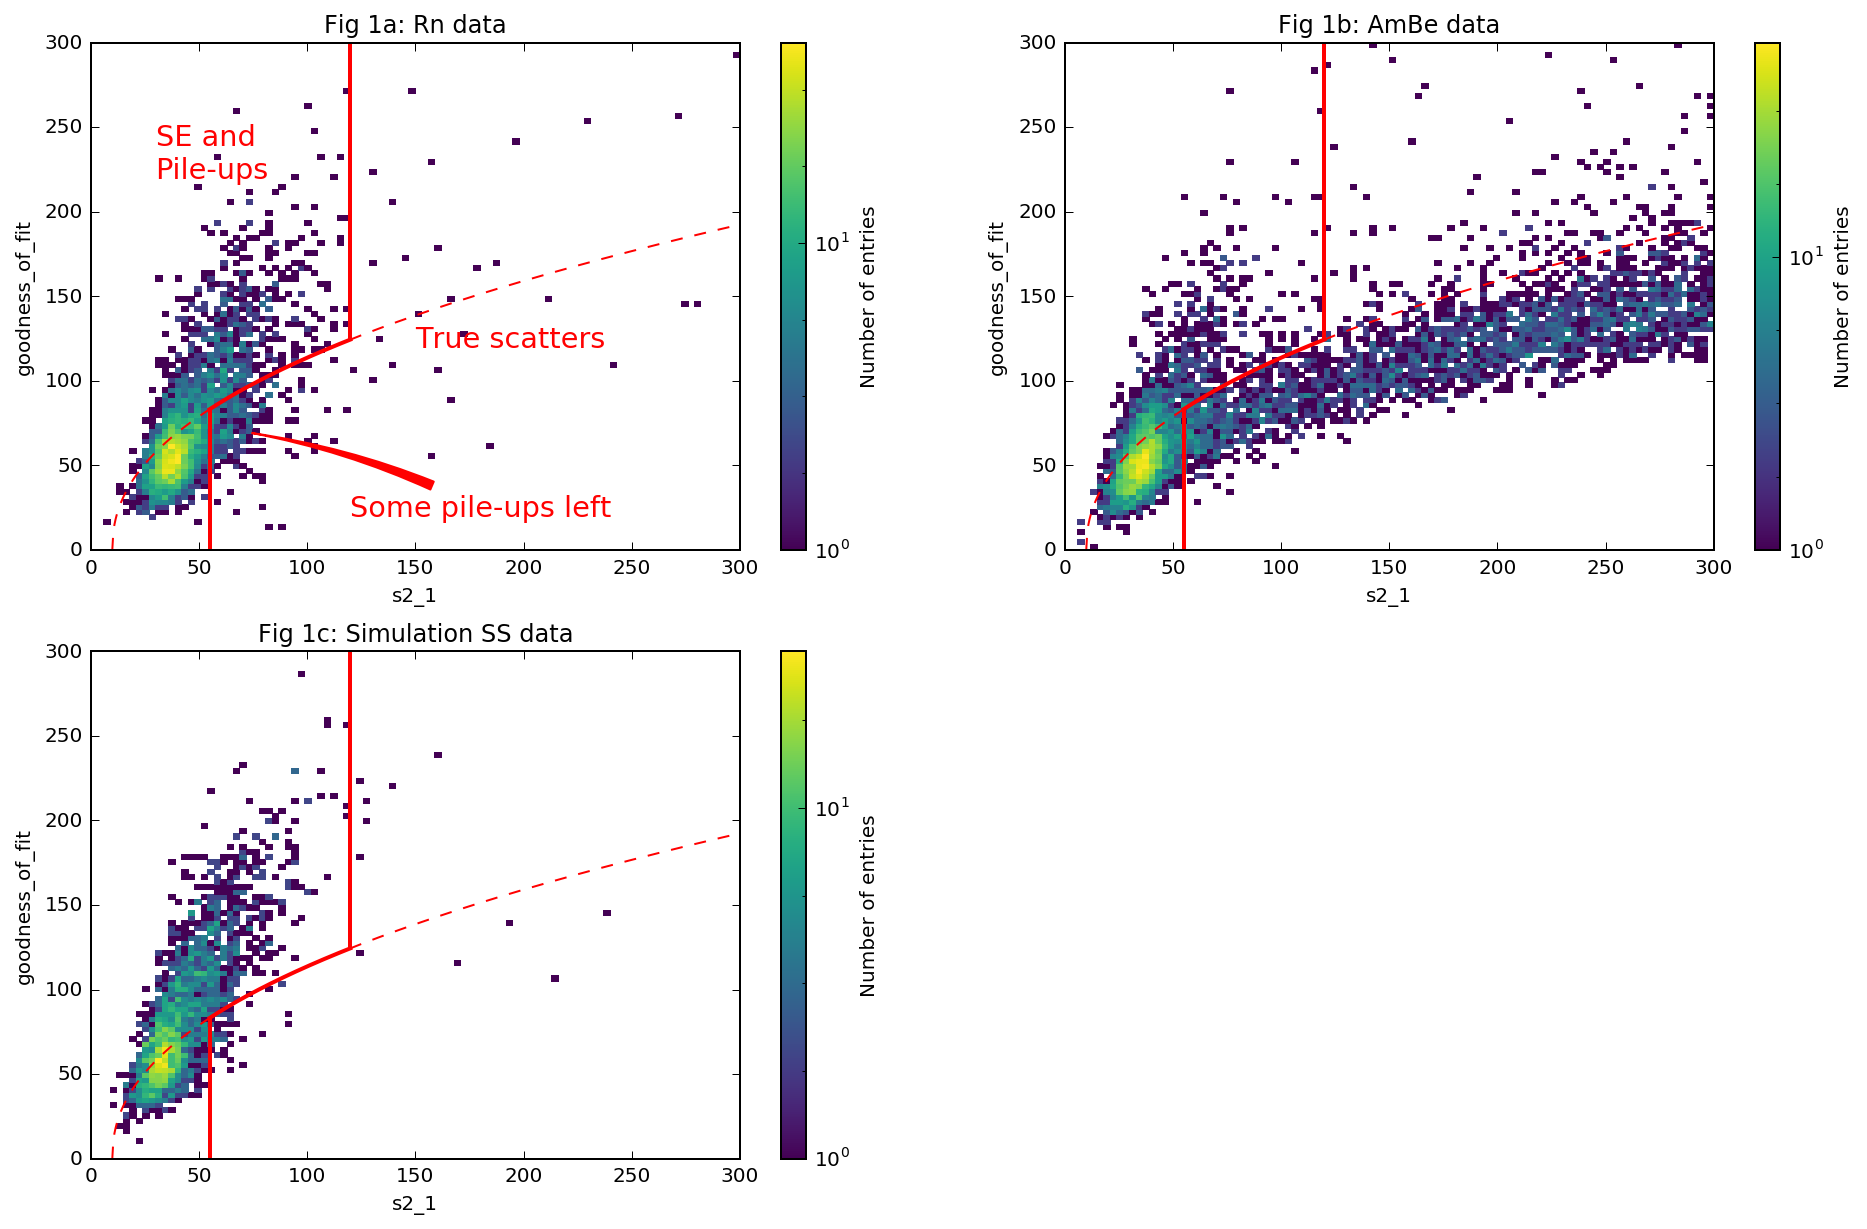

In [8]:
#########################Here we define the cut##################
plt.rcParams['figure.figsize'] = (16, 10)
fig = plt.figure()

def plotsups(text = False):
    x = np.linspace(55,120,141)
    y = np.linspace(0,300,601)
    plt.plot(x, 15 * (x -10) **0.45, 'r-', lw = 2.0)
    plt.axvline(120, ymin = 0.415, color = 'r', ls = '-', lw = 2.0)
    plt.axvline(55, ymax = 0.275, color = 'r', ls = '-', lw = 2.0)
    plt.plot(y, 15 * (y -10) **0.45, 'r--')
    if text:  
        plt.text(30,220,'SE and\nPile-ups',color = 'r', size = 14.4)
        plt.text(150,120,'True scatters',color = 'r', size = 14.4)
        plt.annotate('Some pile-ups left', (70, 70), (180,20), color = 'r',
                     ha="center", size=0.2 * 72, transform=fig.transFigure,
                     arrowprops=dict(arrowstyle='wedge', shrinkA=5, shrinkB=5, fc="r", ec="r", connectionstyle="arc3,rad=0.08"))

#####################################################################
df_ = df_rn
with plotting2d(221):
    mh = Histdd(getattr(df_, area), getattr(df_, gof),
                axis_names = ('s2_1', 'goodness_of_fit'),
                bins = (np.linspace(0,300,101), np.linspace(0,300,101)))
plt_config(title = 'Fig 1a: Rn data')
plotsups(text = True)

#####################################################################
df_ = df_nt
with plotting2d(222):
    mh = Histdd(getattr(df_, area), getattr(df_, gof),
                axis_names = ('s2_1', 'goodness_of_fit'),
                bins = (np.linspace(0,300,101), np.linspace(0,300,101)))
plt_config(title = 'Fig 1b: AmBe data')
plotsups()

#####################################################################
df_ = df_si
with plotting2d(223):
    mh = Histdd(getattr(df_, area), getattr(df_, gof),
                axis_names = ('s2_1', 'goodness_of_fit'),
                bins = (np.linspace(0,300,101), np.linspace(0,300,101)))
plt_config(title = 'Fig 1c: Simulation SS data')
plotsups()

plt.show()

In __figure__ 1a and 1b, we compare Radon and AmBe largest_other_s2, the vertical line to the left is 55 pe threshold for SEs, the one to the right is there to keep out peaks whose area is too large so that we leave them to time delay cut to dicide.

The curve here is not so much different from S2PatternLikelihood cut designed for main S2 by Bart Pelssers [link here](https://xecluster.lngs.infn.it/dokuwiki/doku.php?id=xenon:xenon1t:analysis:firstresults:s2_pattern_likelihood_cut). But we made some modifications for the area range we are interested in (which is much lower than main s2).

__b2)__ __Time Delay from main S2__

- Multiple scatter from neutron also have a distinct mean free path between each scatter which is (partially) reflected in data as the time difference between largest_other_s2 and main s2. Thus having a time delay related cut is reasonable, on the other hand we want minimal removal of pile-up peaks, and additionally we want a dependence on main S2 area. Which demands our cut to be a surface in 3-dimensional (main s2 area, time delay from s2 and largest_other_s2 area).
    - The surface we come up with can be fomulated as parabolas of largest_other_s2 area vs. time delay whose vertexes rise as main S2 increases.

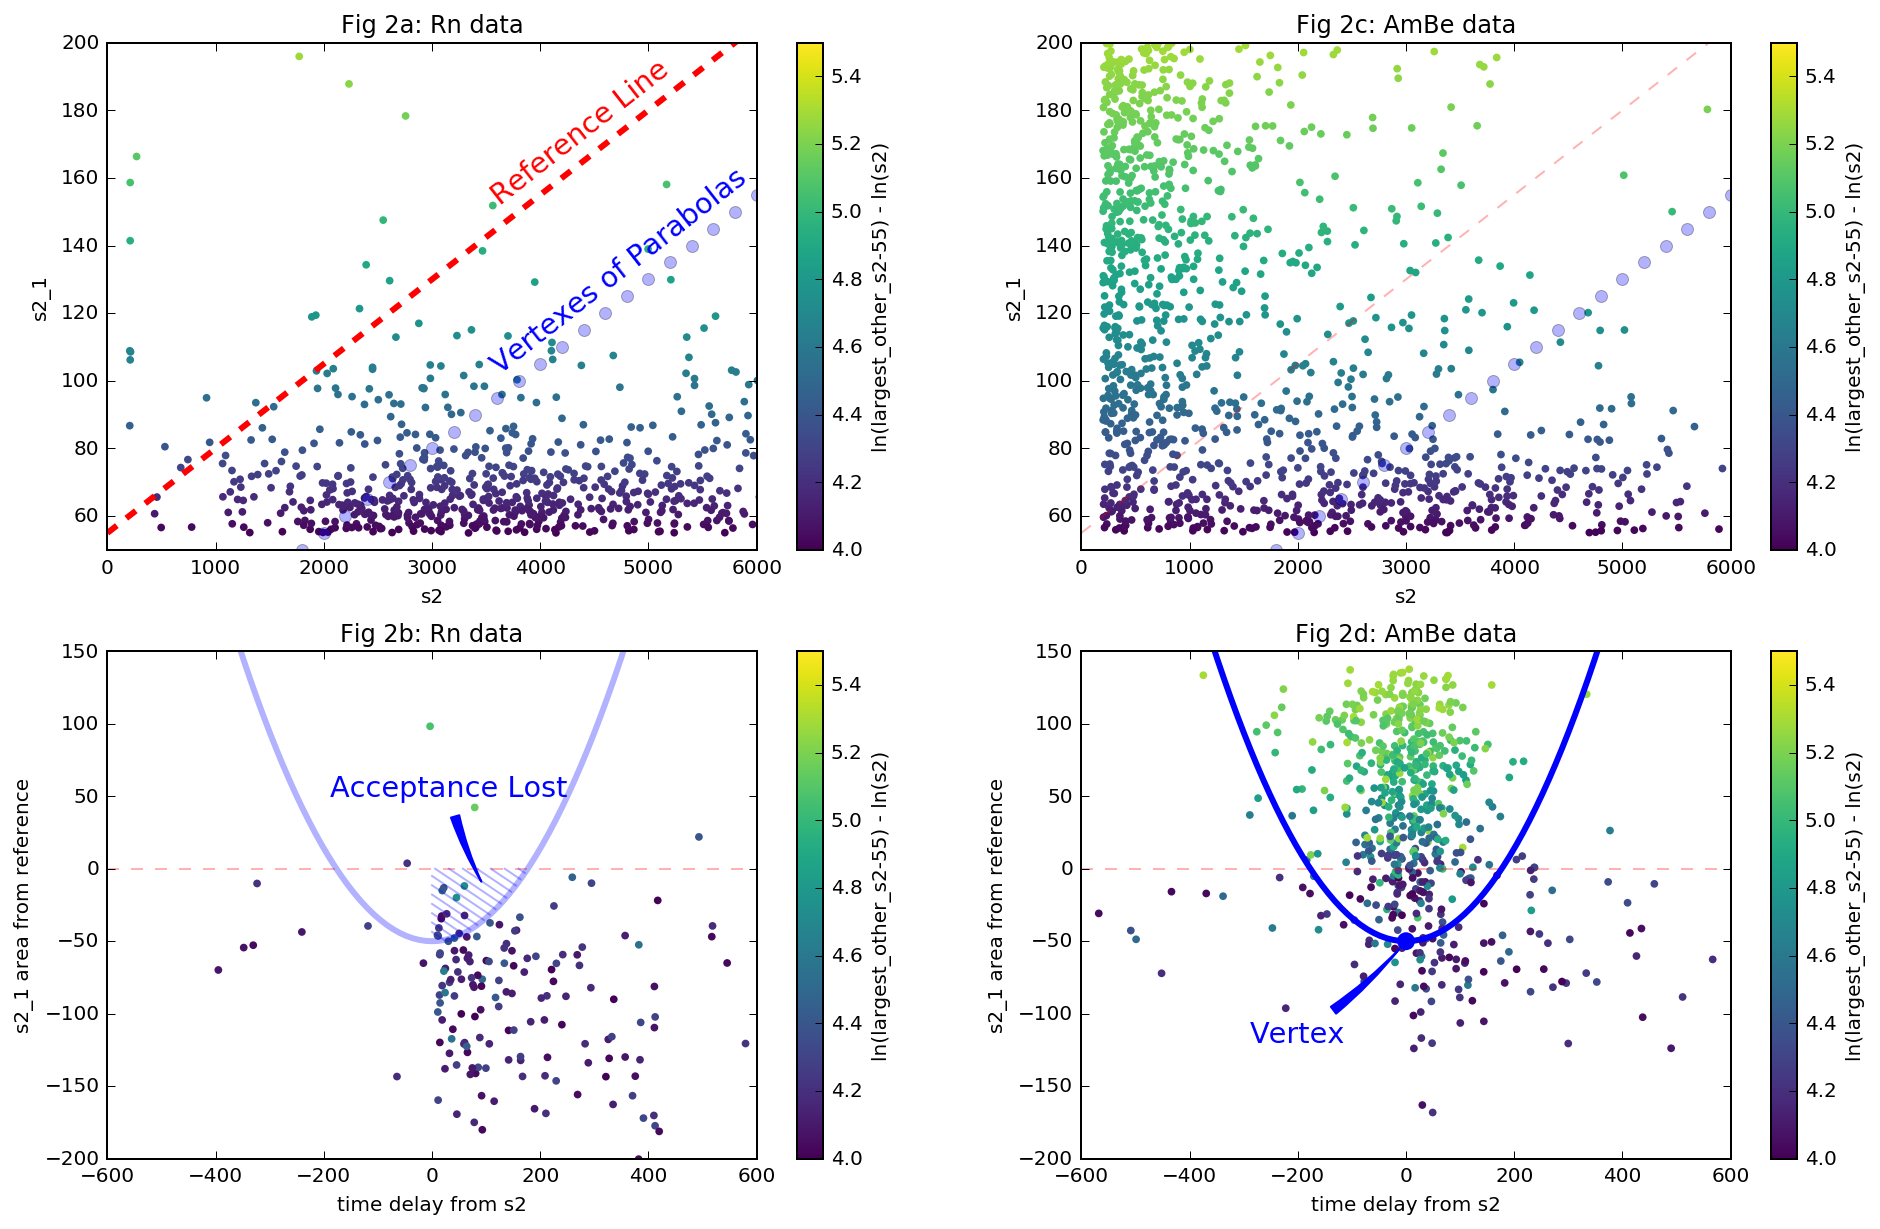

In [9]:
import matplotlib.patches as mpatch

#########################Here we define the cut##################
plt.rcParams['figure.figsize'] = (16, 10)
fig = plt.figure()

x = np.linspace(0,6000,31)
y = np.linspace(-6e2, 6e2, 101) + 0j

ops = dict(s=15, edgecolor='none', cmap=plt.get_cmap('viridis'))
ops_2 = dict(xbounds = [0,6e3], ybounds = [50,200], colorbar = 'ln(largest_other_s2-55) - ln(s2)', xlabel = 's2', ylabel = 's2_1', sci = False)
ops_3 = dict(xbounds = [-6e2,6e2], ybounds = [-200,150], colorbar = 'ln(largest_other_s2-55) - ln(s2)', xlabel = 'time delay from s2', ylabel = 's2_1 area from reference', sci = False)
#####################################################################
ax = fig.add_subplot(221)
df_ = (sel_notse((sel_pu(df_rn))))
plt.scatter(getattr(df_, 's2'), getattr(df_, area), 
            c = np.log(getattr(df_, area) - 55 / getattr(df_, 's2')), vmin = 4, vmax = 5.5,  **ops)
plt_config(title = 'Fig 2a: Rn data', **ops_2)
plt.plot(x, 55 + x * 0.025, 'r--', lw = 3.0)
plt.plot(x, x * 0.025 + 5, 'bo', lw = 1.0, alpha = 0.3)
plt.text(3500,190,'Reference Line',color = 'r', size = 14.4, rotation = 38)
plt.text(3500,158,'Vertexes of Parabolas',color = 'b', size = 14.4, rotation = 38)

#####################################################################
ax = fig.add_subplot(223)
df_ = sel_notse(sel_notpu(df_rn))
plt.scatter(getattr(df_, dt2)/1e3,(getattr(df_, area) - 55) - getattr(df_, 's2') * 0.025,
            c = np.log(getattr(df_, area) - 55 / getattr(df_, 's2')), vmin = 4, vmax = 5.5, **ops)
plt_config(title = 'Fig 2b: Rn data', **ops_3)
plt.axhline(0, color = 'r', ls = '--', lw = 1.0, alpha = 0.3)
plt.plot(y, (y/25)**2 - 50, 'b-', lw = 3.0, alpha = 0.3)
for c in np.linspace(0, 360, 15):
    a = np.linspace(np.clip(c-200, 0, 500), ((0.0256*c+1)**0.5-1)/0.0128, 11)
    b = -a/4 + c/4 - 50
    plt.plot(a, b, 'b-', lw = 1.0, alpha = 0.3)
    
plt.annotate('Acceptance Lost', (100, -15), (30,50), color = 'b',
             ha="center", size=0.2 * 72, transform=fig.transFigure,
             arrowprops=dict(arrowstyle='wedge', shrinkA=5, shrinkB=5, fc="b", ec="b", connectionstyle="arc3,rad=0.08"))


#####################################################################
ax = fig.add_subplot(222)
df_ = (sel_notse((sel_pu(df_nt))))
plt.scatter(getattr(df_, 's2'), getattr(df_, area),
            c = np.log(getattr(df_, area) - 55 / getattr(df_, 's2')), vmin = 4, vmax = 5.5, **ops)
plt_config(title = 'Fig 2c: AmBe data', **ops_2)
plt.plot(x, 55 + x * 0.025, 'r--', lw = 1.0, alpha = 0.3)
plt.plot(x, x * 0.025 + 5, 'bo', lw = 1.0, alpha = 0.3)

#####################################################################
ax = fig.add_subplot(224)
df_ = sel_notse(sel_notpu(df_nt))
plt.scatter(getattr(df_, dt2)/1e3,(getattr(df_, area) - 55) - getattr(df_, 's2') * 0.025,
            c = np.log(getattr(df_, area) - 55 / getattr(df_, 's2')), vmin = 4, vmax = 5.5, **ops)
plt_config(title = 'Fig 2d: AmBe data', **ops_3)
plt.axhline(0, color = 'r', ls = '--', lw = 1.0, alpha = 0.3)
plt.plot(y, (y/25)**2 - 50, 'b-', lw = 3.0)
plt.scatter(0, -50,c = 'b', s=80, edgecolor='none')
plt.annotate('Vertex', (0, -50), (-200,-120), color = 'b',
             ha="center", size=0.2 * 72, transform=fig.transFigure,
             arrowprops=dict(arrowstyle='wedge', shrinkA=5, shrinkB=5, fc="b", ec="b", connectionstyle="arc3,rad=0.08"))

plt.show()

1) Based on SS samples (Rn220 data as well as simulated ones) we first choose a reference line so that most pile-ups falls blow (all largest_other_s2s in simulation). Shown in __figure 2a__

2) Then we substract the reference from all largest_other_s2 for AmBe data, and plot them against time delay from s2. And we use a parabola to define the devision between pile up and true scatter. The reason we choose parabola is because is simplicity as well as it's a even function. Shown in __figure 2d__

3) We also want sacrifice as little pile-ups as possible, so we check the cut in __figure 2b__ the theoretical acceptance lost should be limited in the shadowed area. While when using Rn220 data we actually lose more, due to more background SE and pile-up peaks. But we would expect a higher acceptance in background runs.

__C)__  __Compare with SR0 Cut__

Using AmBe and Rn220 as MS and SS samples, we plot the cut result in the original s2-largest_other_s2 space. We can see below that compare to old SR0 cut, this new one can keep more Rn220 data in __figure 3a__ while remove more AmBe MS events in __figure 3d__

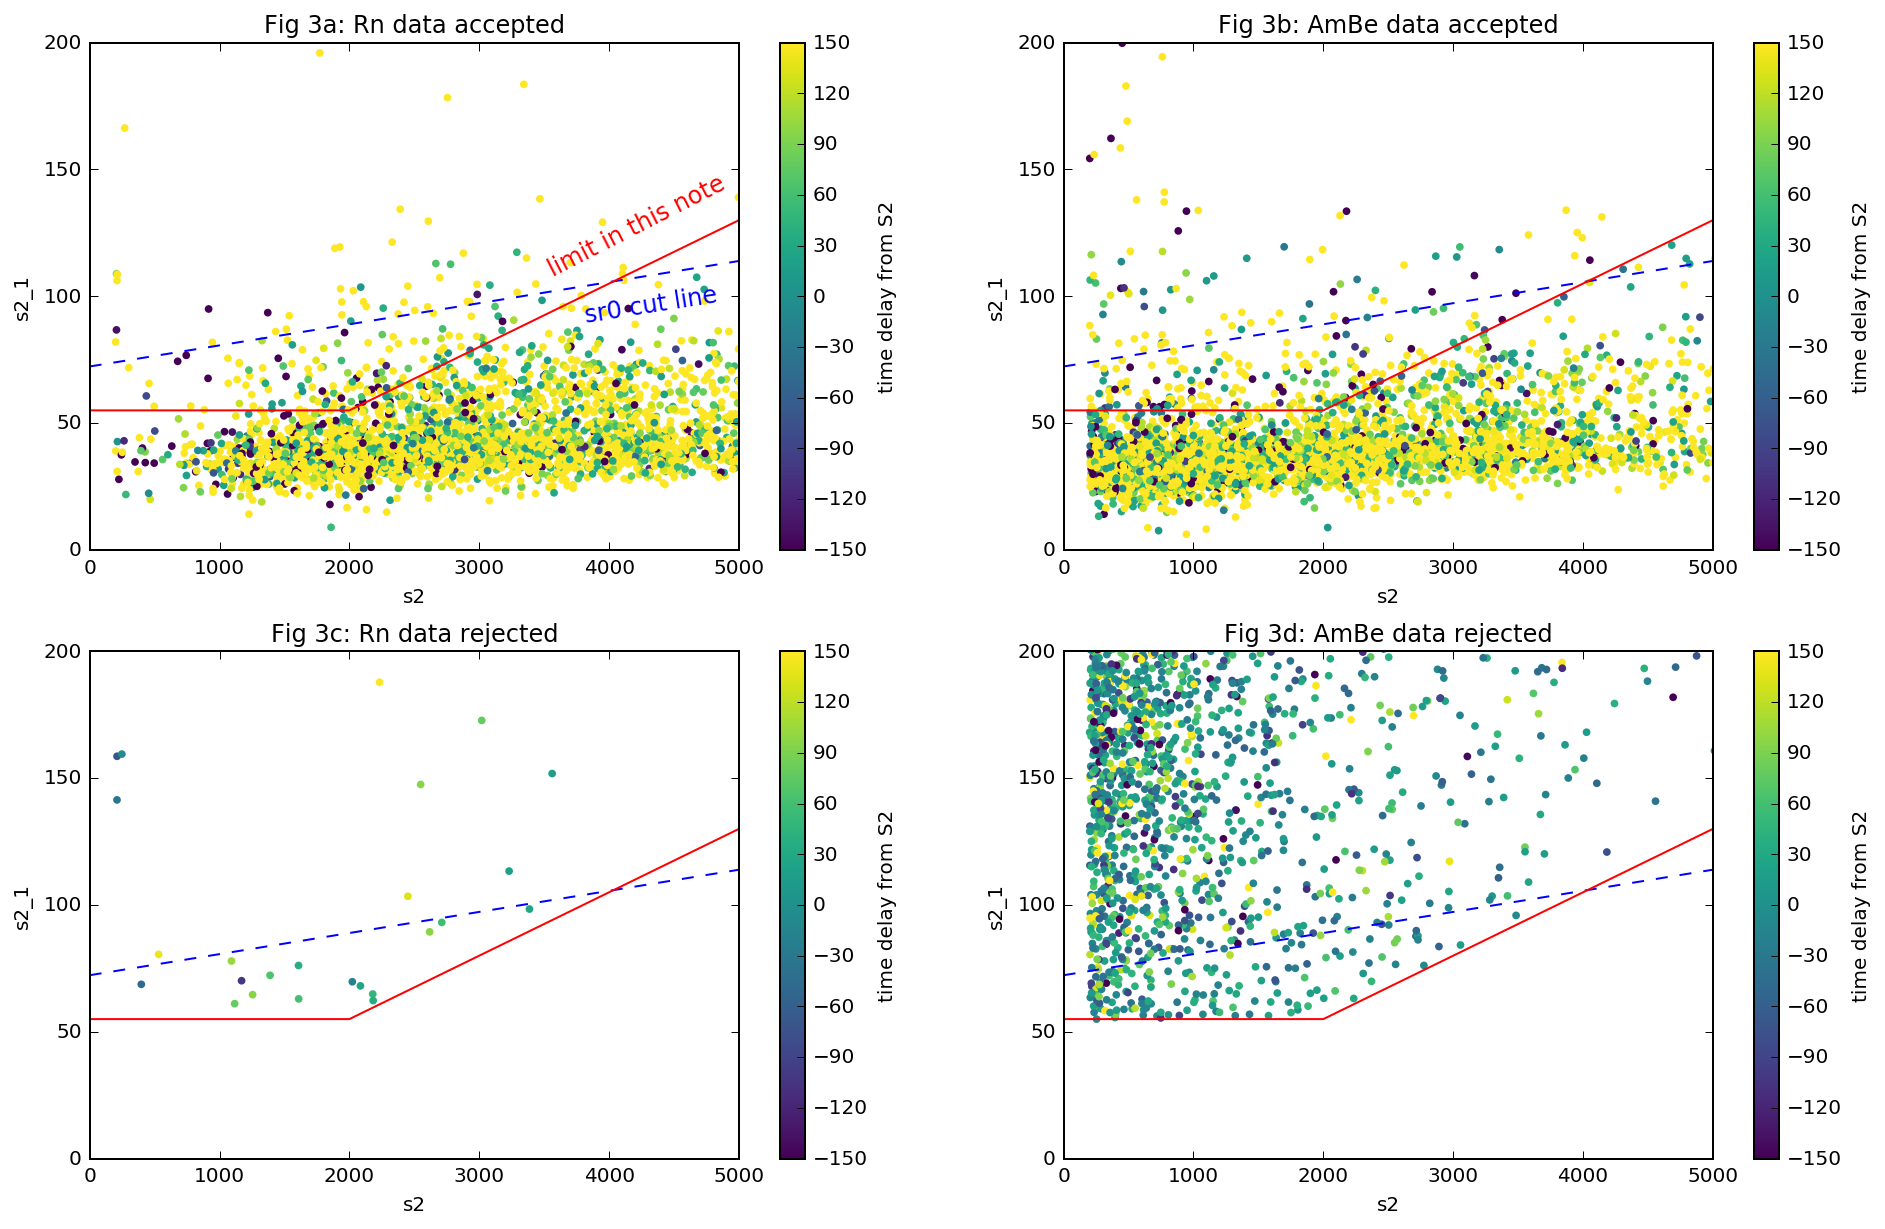

In [10]:
plt.rcParams['figure.figsize'] = (16, 10)
fig = plt.figure()

def plotsups(text = False):
    x = np.linspace(0,8e3,101)
    plt.plot(x, ses2_size_cut_ori(x), 'b--')
    plt.plot(x, np.clip(5 + x * 0.025, 55, 1e5), 'r-')
    if text:
        plt.text(3800, 98, 'sr0 cut line', color = 'b', size = 12.0, rotation=9)
        plt.text(3500, 142, 'limit in this note', color = 'r', size = 12.0, rotation=27)

    
ops = dict(s=15, edgecolor='none', cmap=plt.get_cmap('viridis'))
ops_2 = dict(xlabel = 's2', ylabel = 's2_1', xbounds = [0,5e3], ybounds = [0,200], colorbar = 'time delay from S2', sci = False)
#####################################################################
ax = fig.add_subplot(221)
df_ = sel_ss(df_rn)
plt.scatter(getattr(df_, 's2'), getattr(df_, area), c = getattr(df_, dt2) / 1000, vmin = -150, vmax = 150, **ops)
plt_config(title = 'Fig 3a: Rn data accepted', **ops_2)
plotsups(text = True)

#####################################################################
ax = fig.add_subplot(222)
df_ = sel_ss(df_nt)
plt.scatter(getattr(df_, 's2'), getattr(df_, area), c = getattr(df_, dt2) / 1000, vmin = -150, vmax = 150, **ops)
plt_config(title = 'Fig 3b: AmBe data accepted', **ops_2)
plotsups()

#####################################################################
ax = fig.add_subplot(223)
df_ = sel_ms(df_rn)
plt.scatter(getattr(df_, 's2'), getattr(df_, area), c = getattr(df_, dt2) / 1000, vmin = -150, vmax = 150, **ops)
plt_config(title = 'Fig 3c: Rn data rejected', **ops_2)
plotsups()

#####################################################################
ax = fig.add_subplot(224)
df_ = sel_ms(df_nt)
plt.scatter(getattr(df_, 's2'), getattr(df_, area), c = getattr(df_, dt2) / 1000, vmin = -150, vmax = 150, **ops)
plt_config(title = 'Fig 3d: AmBe data rejected', **ops_2)
plotsups()

plt.show()

__D)__  __Calculate Cut Efficiency Using Data__

Although using data to calculate rejection power is affected by multiple choices made along the way (described in SR0 note, but the acceptance can be relatively good)

The next step would be match fax simulation with data and use simulation to calculate cut efficiencies.

In [11]:
diffusion_constant = 2.280000e-08 #pax_config['WaveformSimulator']['diffusion_constant_liquid']
v_drift = 1.440000e-04 #pax_config['DEFAULT']['drift_velocity_liquid']
def s2_width_model(z):
        w0 = 337.3
        return np.sqrt(w0 ** 2 - 5.7370 * diffusion_constant * z / v_drift ** 3)
    
def s2_width_bounds(dt, kind='high'):
    if kind == 'high':
        return (0.8 + 0.5/500*dt)*0.9 + s2_width_model(-dt*v_drift)
    if kind == 'low':
        return (-0.4 - 0.5/500*dt)*0.9 + s2_width_model(-dt*v_drift)

sel_mul = lambda df: df[((df.source__type == 'AmBe') | (df.source__type == 'Rn220') | (df.source__type == 'neutron_generator')) &
                        (df.s2_1_delay_is1>80e3) & (df.s2_1_delay_is1<670e3) &
                        (df.s2_1_range_50p_area>s2_width_bounds(df.s2_1_delay_is1,'low')) & 
                        (df.s2_1_range_50p_area<s2_width_bounds(df.s2_1_delay_is1,'high')) &
                        (np.log10(df.cs2/df.cs1) < np.log10(5000/df.cs1)+8e-4*df.cs1)
                       ]

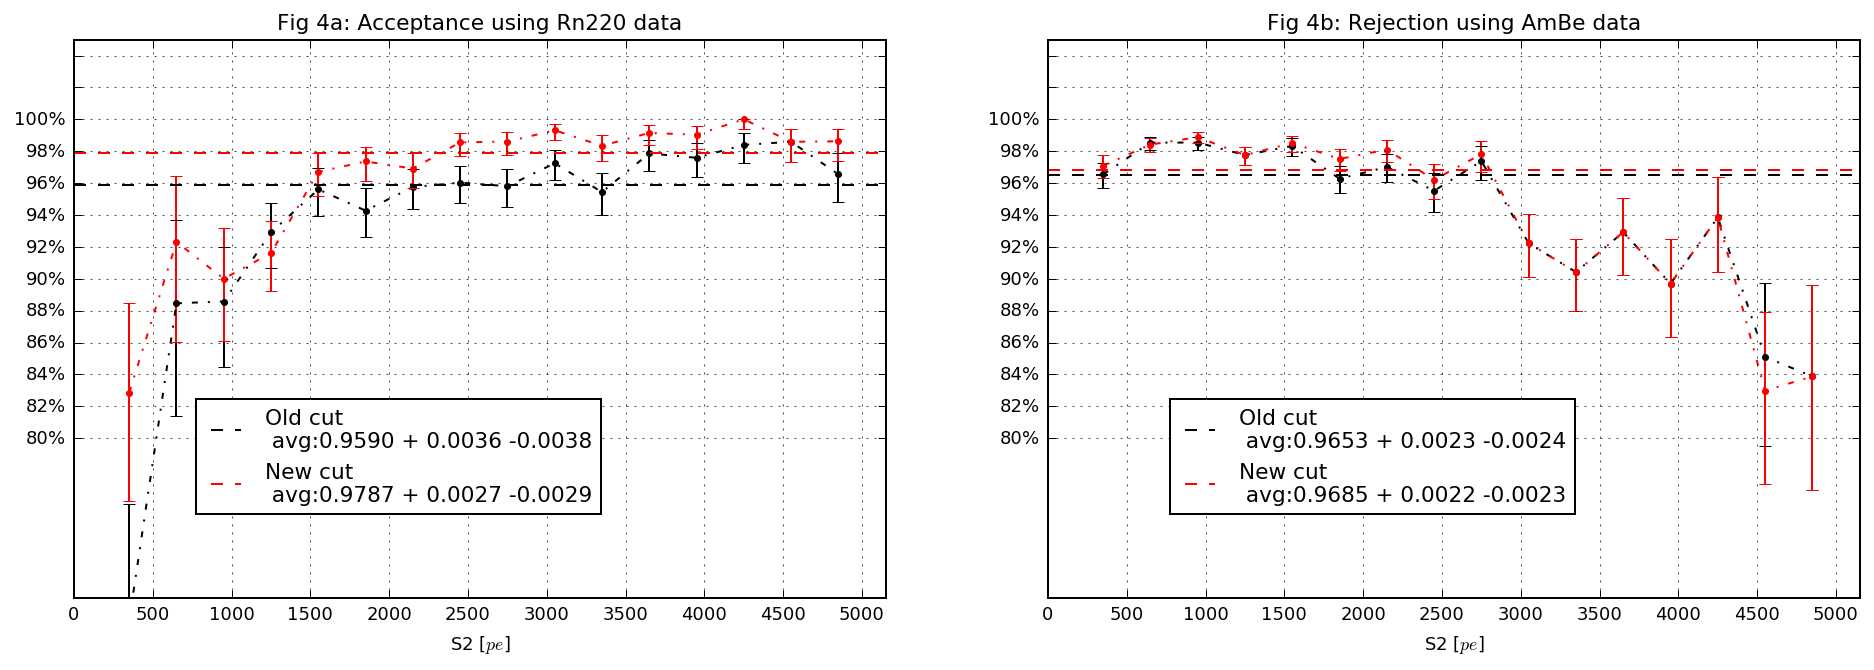

In [12]:
matplotlib.rc('font', size = 9)
plt.rcParams['figure.figsize'] = (16, 5)
fig = plt.figure()
from scipy.stats import beta

labels = ['%d%%'%(i*2+80) for i in range(11)]
handles = []

def f(x,rv):
    return rv.ppf(rv.cdf(x)+0.68)-x

def error_eff(pha,pht):
    rv = [beta(pha[i]+1,pht[i]-pha[i]+1) for i in range(len(pha[:]))]
    bounds = [(rv[i].ppf(0),rv[i].ppf(0.319)) for i in range(len(pha[:]))]
    low = [pha[i]/pht[i]-minimize(f,0.1,rv[i],bounds=(bounds[i],)).x[0] for i in range(len(pha[:]))]
    high = [f(pha[i]/pht[i]-low[i],rv[i])-low[i] for i in range(len(pha[:]))]
    return low,high

def plot_eff(c,eff_type = 'acc',bias = 0.7,cut = None, title = ''):    
    mh = Histdd(getattr(df_, 's2'), getattr(df_, 'acc'),
                bins=(np.linspace(s2_0_bounds[0], s2_0_bounds[1], 17), np.linspace(-0.5, 1.5, 3)))
    pht= mh.projection(axis=0)
    pha = mh.average(axis=1).histogram * pht.histogram
    low,high = error_eff(pha,pht)
    low_t,high_t = error_eff([sum(pha[:])],[sum(pht[:])])
    global handles
    plt.errorbar(pht.bin_centers,pha[:]/pht[:]-bias,yerr=[low,high],fmt='.',color=c,ls='-.',capsize=3.,
                         label = '%s cut\n avg:%.4f + %.4f -%.4f' % (title,np.average(df_.acc),high_t[0],low_t[0]) 
                        ) 
    
    ops = dict(xmin=0, xmax=1, color=c, ls='--', lw=1.)
    line = plt.axhline(y=np.average(df_.acc)-bias, label = '%s cut\n avg:%.4f + %.4f -%.4f' % (title,np.average(df_.acc),high_t[0],low_t[0]) , **ops )
    handles.append(line)
    #plt.axhline(y=np.average(df_.acc)-bias-low, alpha =0.3, **ops)
    #plt.axhline(y=np.average(df_.acc)-bias+high, alpha =0.3, **ops)
    
    return np.average(df_.acc), low[0], high[0]

########################_efficiency plots_########################
ax = fig.add_subplot(121)

s2_0_bounds, s2_1_bounds = [200,5000], [0,500]
df_ = df_rn
df_['acc'] = 0
df_.loc[getattr(df_, area) < ses2_size_cut_ori(getattr(df_, 's2')),'acc'] = 1
acc_old, low_o, high_o = plot_eff('k',eff_type ='acc',bias = 0.7,title = 'Old')
df_['acc'] = 0
df_.loc[(getattr(df_, area) < 55) | ((getattr(df_, area) < 120) & (getattr(df_, gof) > 15 * (getattr(df_, area) -10) ** 0.45)) | (getattr(df_, area) - 5 - getattr(df_, 's2') * 0.025 < (getattr(df_, dt2) / 2.5e4) ** 2),
        'acc'] = 1
acc_new, low_n, high_n = plot_eff('r',eff_type ='acc',bias = 0.7,title = 'New')

plt.legend(handles = handles, loc = [0.15,0.15])

plt.xticks(np.asarray([i*500 for i in range(11)]),color='k')
plt.yticks(np.asarray([i*0.02+0.1 for i in range(16)]),labels,color='k')
ax.grid(which = 'minor', alpha = 0.3)
ax.grid(which = 'major', alpha = 0.7)
plt_config(title = 'Fig 4a: Acceptance using Rn220 data', xbounds = [0,5150], ybounds = [0,0.35],
           xlabel = 'S2 [$pe$]', ylabel = '',colorbar = False, sci = False)

########################_efficiency plots_########################
ax = fig.add_subplot(122)

handles = []
s2_0_bounds, s2_1_bounds = [200,5000], [0,500]
df_ = sel_mul(df_nt)
df_['acc'] = 0
df_.loc[getattr(df_, area) > ses2_size_cut_ori(getattr(df_, 's2')),'acc'] = 1
acc_old, low_o, high_o = plot_eff('k',eff_type ='rej',bias = 0.7,title = 'Old')
df_['acc'] = 0
df_.loc[(getattr(df_, area) > 55) & ((getattr(df_, area) > 120) | (getattr(df_, gof) < 15 * (getattr(df_, area) -10) ** 0.45)) & (getattr(df_, area) - 5 - getattr(df_, 's2') * 0.025 > (getattr(df_, dt2) / 2.5e4) ** 2),
        'acc'] = 1
acc_new, low_n, high_n = plot_eff('r',eff_type ='rej',bias = 0.7,title = 'New')

plt.legend(handles = handles, loc = [0.15,0.15])

plt.xticks(np.asarray([i*500 for i in range(11)]),color='k')
plt.yticks(np.asarray([i*0.02+0.1 for i in range(16)]),labels,color='k')
ax.grid(which = 'minor', alpha = 0.3)
ax.grid(which = 'major', alpha = 0.7)
plt_config(title = 'Fig 4b: Rejection using AmBe data', xbounds = [0,5150], ybounds = [0,0.35],
           xlabel = 'S2 [$pe$]', ylabel = '',colorbar = False, sci = False)


plt.show()